# Solving the Problem

### Here i present my solution to this particular problem presented to me this afternoon

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits import mplot3d
sns.distributions._has_statsmodels=False
df=pd.read_excel("TESTING BD.xlsx")
names=df.columns
df.columns=[0]
df_to_explore=df[0].str.split(",",expand=True)
df_to_explore.columns=names[0].split(",")
int_type=["Customer Lifetime Value","Income", "Monthly Premium Auto",
 "Months Since Last Claim","Months Since Policy Inception",
 "Number of Open Complaints","Number of Policies","Total Claim Amount"]
# Transform data
for i in int_type:
    df_to_explore[i]=df_to_explore[i].astype(float)
df_to_explore["Effective To Date"]=pd.to_datetime(df_to_explore["Effective To Date"])

# Lets check the importance of the variables

In [2]:
df_to_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Customer                       9134 non-null   object        
 1   State                          9134 non-null   object        
 2   Customer Lifetime Value        9134 non-null   float64       
 3   Response                       9134 non-null   object        
 4   Coverage                       9134 non-null   object        
 5   Education                      9134 non-null   object        
 6   Effective To Date              9134 non-null   datetime64[ns]
 7   EmploymentStatus               9134 non-null   object        
 8   Gender                         9134 non-null   object        
 9   Income                         9134 non-null   float64       
 10  Location Code                  9134 non-null   object        
 11  Marital Status   

# What about correlations?

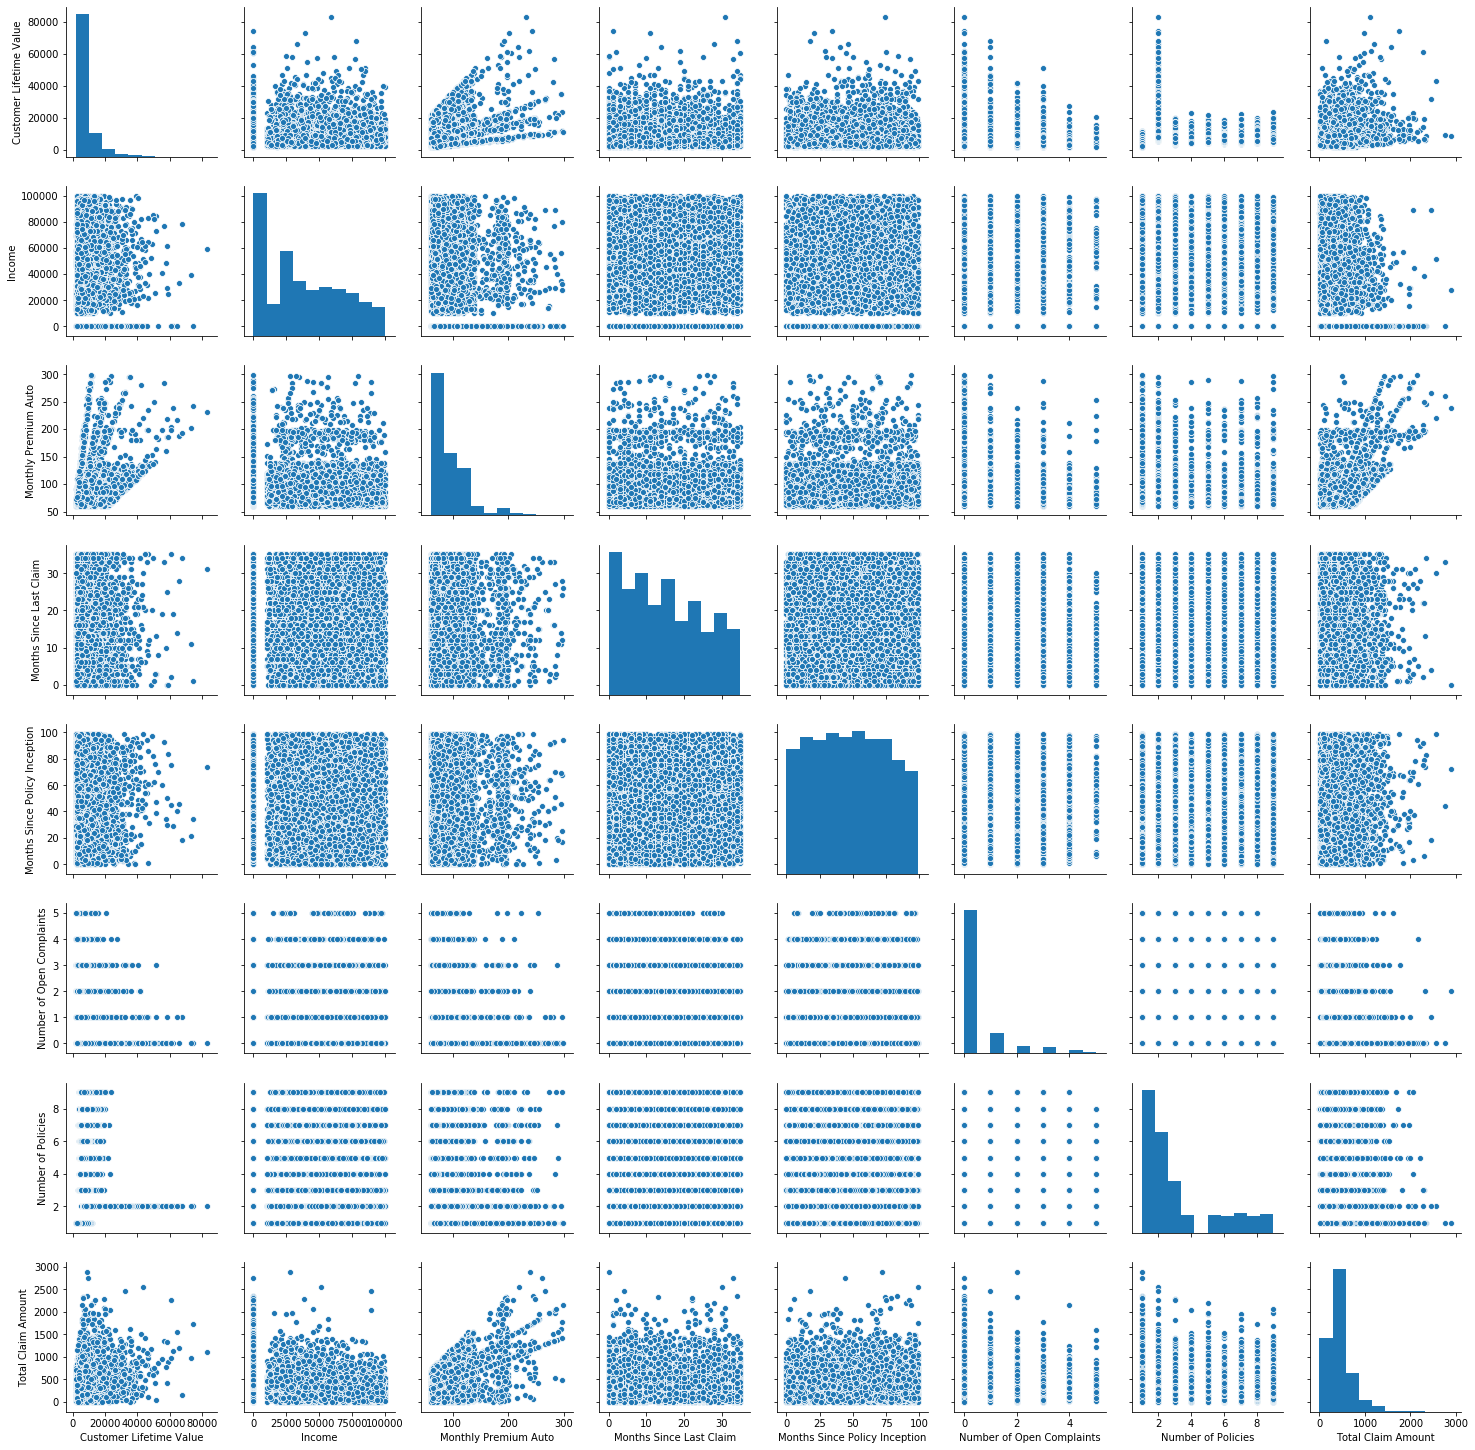

In [3]:
sns.pairplot(data=df_to_explore)

# And maybe segmenting by Sales channel

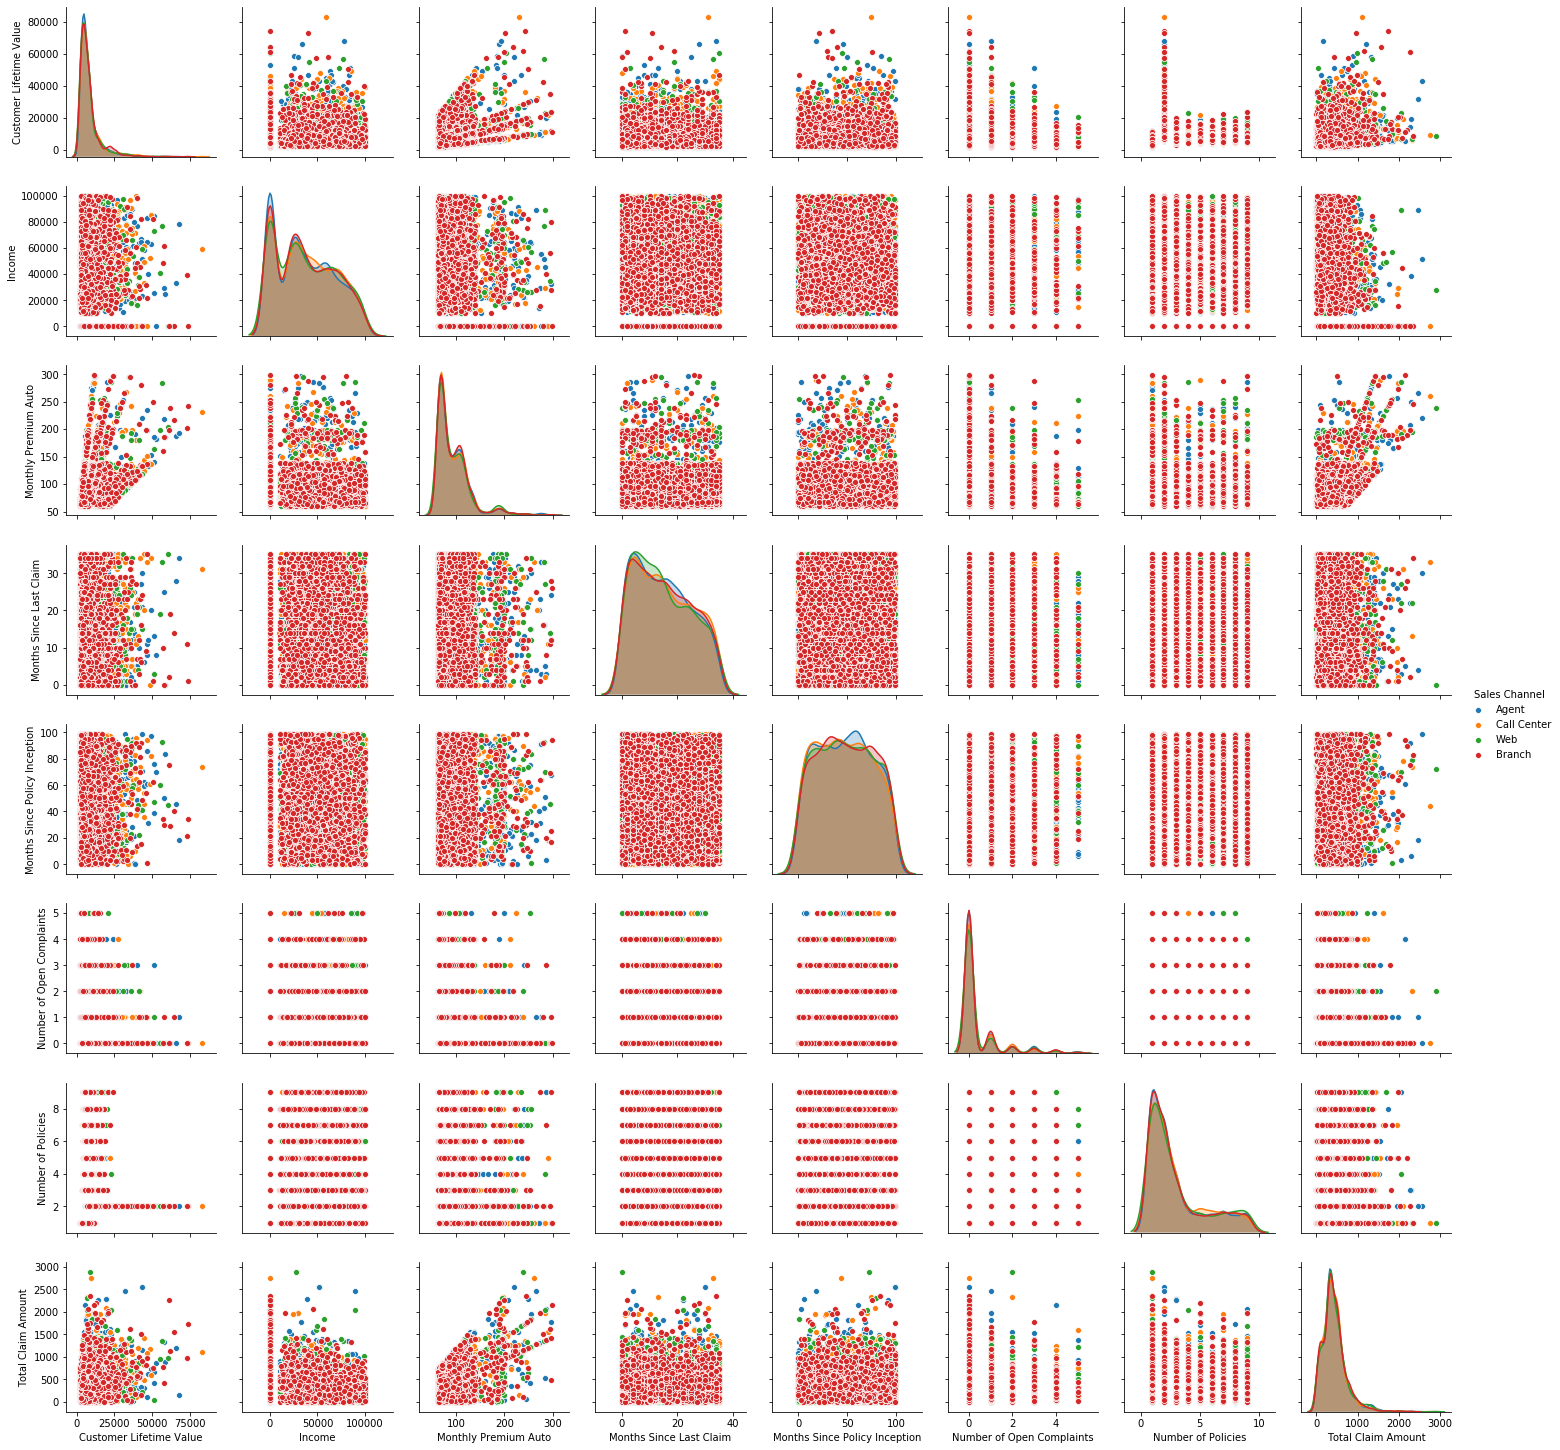

In [4]:
sns.pairplot(data=df_to_explore,hue="Sales Channel")

# Gender?

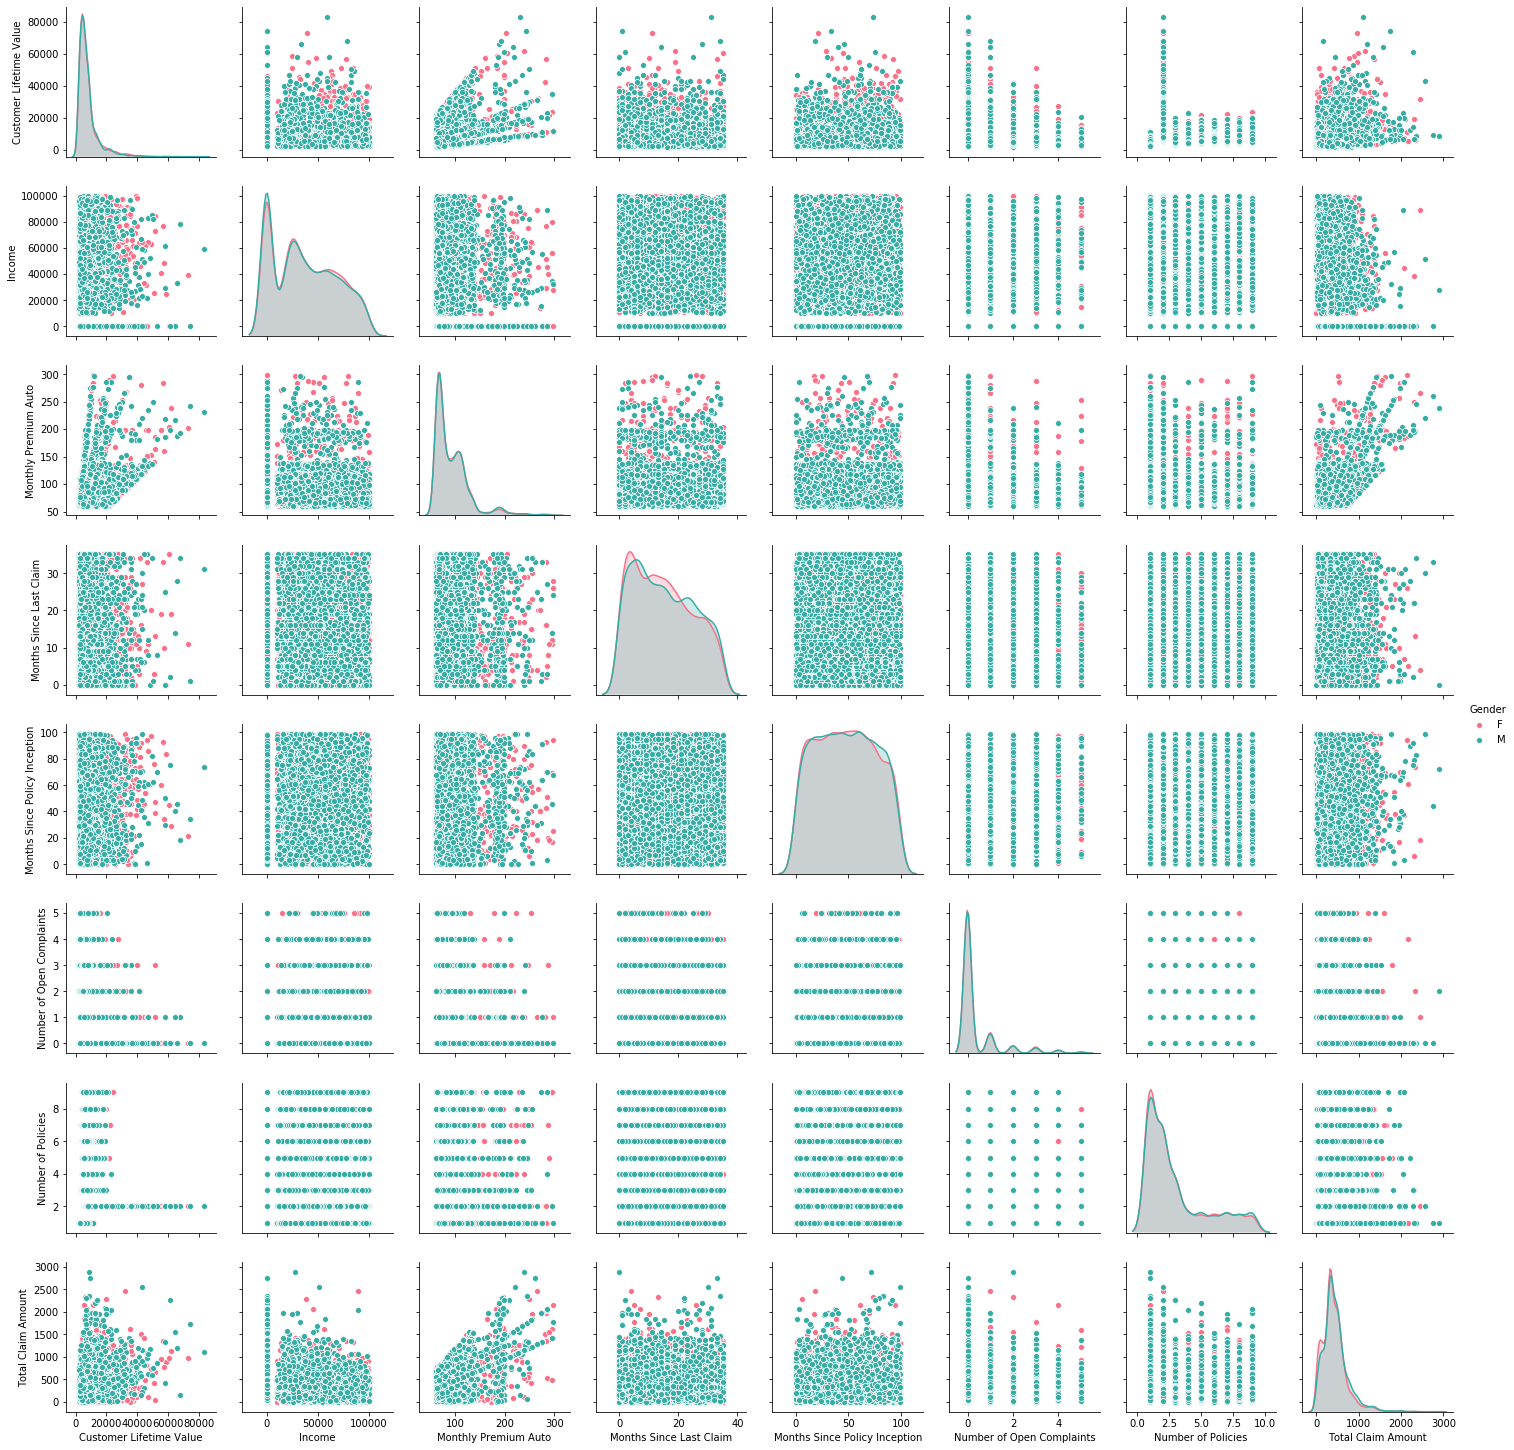

In [5]:
sns.pairplot(data=df_to_explore,hue="Gender",palette="husl")

### The distribution of the Data looks all the same, therefore the is no difference at all between the different channels nor in the gender of the users.

# Segmenting by state and sales channel

In [6]:
df_to_explore.groupby(["Sales Channel","State","Response"]).agg(Total=("Gender","count"))

Total
Sales Channel State      Response       
Agent         Arizona    No          518
                         Yes         125
              California No          981
                         Yes         220
              Nevada     No          267
                         Yes          63
              Oregon     No          787
                         Yes         201
              Washington No          258
                         Yes          57
Branch        Arizona    No          422
                         Yes          47
              California No          788
                         Yes         112
              Nevada     No          219
                         Yes          28
              Oregon     No          639
                         Yes          80
              Washington No          205
                         Yes          27
Call Center   Arizona    No          313
                         Yes          40
              California No          530
                         Yes          75
              Nevada     No          148
                         Yes          15
              Oregon     No          447
                         Yes          50
              Washington No          135
                         Yes          12
Web           Arizona    No          207
                         Yes          31
              California No          395
                         Yes          49
              Nevada     No          124
                         Yes          18
              Oregon     No          352
                         Yes          45
              Washington No           91
                         Yes          13

# It is hard to see, let's plot it

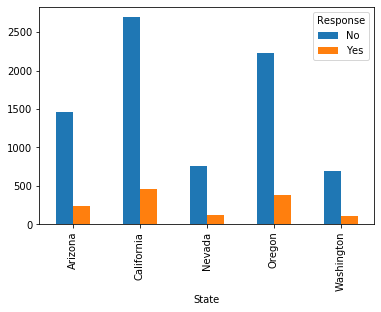

In [7]:
df_to_explore.groupby(["State","Response"]).agg(Total=("Gender","count")).unstack(1)["Total"].plot(kind="bar")
plt.show()

# We could also check the percentage of engagement segmenting by the offer

In [8]:
df_tmp=df_to_explore.groupby((["Renew Offer Type","Response"])).agg(Percentage=("Gender","count"))
df_tmp.groupby(level=0).apply(lambda x: 100*x / float(x.sum()))

Percentage
Renew Offer Type Response            
Offer1           No         84.168443
                 Yes        15.831557
Offer2           No         76.623377
                 Yes        23.376623
Offer3           No         97.905028
                 Yes         2.094972
Offer4           No        100.000000

# having more granularity we can check the type of car of the User

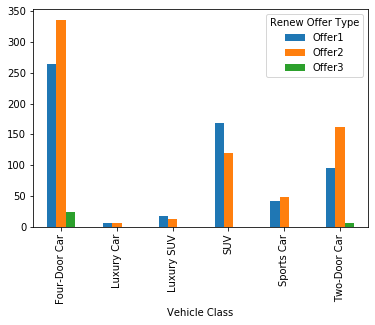

In [9]:
df_to_explore[df_to_explore["Response"]=="Yes"].groupby((["Vehicle Class","Renew Offer Type"])).agg(Total=("Gender","count"))["Total"].unstack().plot(kind="bar")

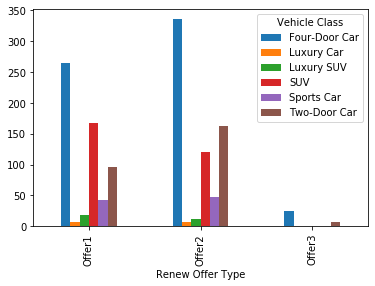

In [10]:
df_to_explore[df_to_explore["Response"]=="Yes"].groupby((["Renew Offer Type", "Vehicle Class"])).agg(Total=("Gender","count"))["Total"].unstack().plot(kind="bar")

## We therefore conclude that the offer that performed the best was the 2 offer and the worts being the 4 

# Getting back to the Sales channel Performance

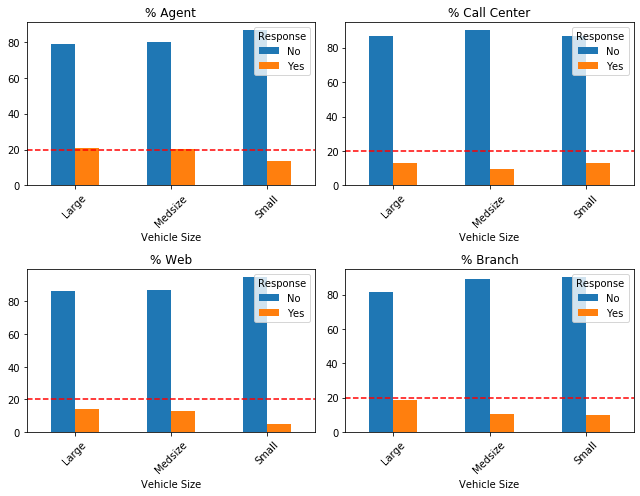

In [11]:
plt.figure(figsize=(9,7))
k=1
for i in df_to_explore["Sales Channel"].unique():
    ax=plt.subplot(2,2,k)
    df_tmp=df_to_explore[df_to_explore["Sales Channel"]==i].groupby(["Vehicle Size","Response"]).agg(Total=("Gender","count"))
    df_tmp.groupby(level=0).apply(lambda x: 100*x / float(x.sum()))["Total"].unstack().plot(kind="bar",ax=ax, rot = 45, title ="% "+i)
    plt.axhline(y=20,color="red",linestyle="--")
    k+=1
plt.tight_layout()
plt.show()

## There is a clear difference between the engagement present in different sales channel when consider the size of the vehicle. For all cases the "medsize" is the size that has better engagement for all channel and again we reinforce what we said before: The channel that performs the best is "Agent" 

In [12]:
conditions = [
    (df_to_explore['Months Since Policy Inception'] <= 20),
    (df_to_explore['Months Since Policy Inception'] > 20) & (df_to_explore['Months Since Policy Inception'] <= 40),
    (df_to_explore['Months Since Policy Inception'] > 40) & (df_to_explore['Months Since Policy Inception'] <= 60),
    (df_to_explore['Months Since Policy Inception'] > 60) & (df_to_explore['Months Since Policy Inception'] <= 80),
    (df_to_explore['Months Since Policy Inception'] > 80) & (df_to_explore['Months Since Policy Inception'] <= 100),
    ]
values = ['New', 'Medium_new', 'Medium_old', 'Old','Quite_old']
df_to_explore['Months range'] = np.select(conditions, values)

conditions = [
    (df_to_explore['Customer Lifetime Value'] <= 5_000),
    (df_to_explore['Customer Lifetime Value'] > 5_000) & (df_to_explore['Customer Lifetime Value'] <= 10_000),
    (df_to_explore['Customer Lifetime Value'] > 10_000) & (df_to_explore['Customer Lifetime Value'] <= 30_000),
    (df_to_explore['Customer Lifetime Value'] > 30_000) ,
    ]
values = ['Low_CLV', 'Avg_CLV', 'High_CLV', 'Special_CLV']
df_to_explore['CLV Range'] = np.select(conditions, values)

# And What about a segmentation of our customers by their CLV and time since they started with our products?

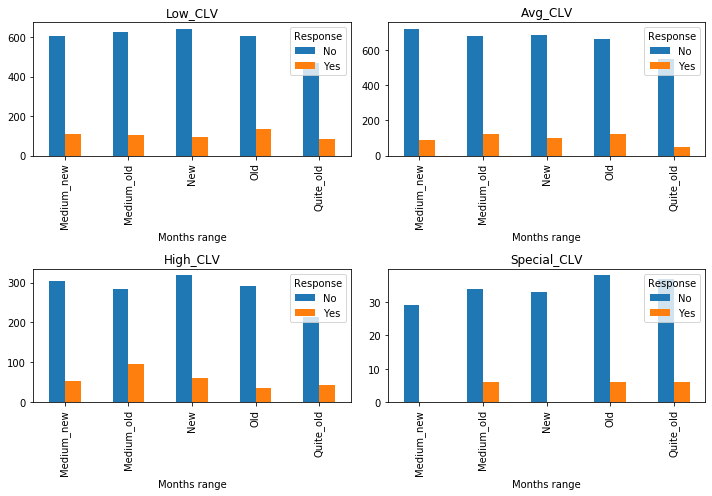

In [13]:
plt.figure(figsize=(10,7))
k=1
for i in df_to_explore["CLV Range"].unique():
    ax=plt.subplot(2,2,k)
    df_to_explore[df_to_explore["CLV Range"]==i].groupby(["Months range","Response"]).agg(Total=("Gender","count"))["Total"].unstack().plot(kind="bar",ax=ax,title=i)
    k+=1
plt.tight_layout()
plt.show()

### For this case we see that people cataloged as "High_CLV" are the ones how performed the best. Something interesting to notice is that for the case of "Special CLV" there is a tendency from the new users as well as the Medium Users to Response "No" being this a sign of alarm to for the enterprise to take actions.

## In order to complement our analysis i wanted to search for a model in which i could differentiate the costumers who answered yes and those who did not.

## We will try to find through a hierarchical cluster the best description of our groups to then classify in a better way our Customers ( better insights about them)

# 1 Case
### Classifying both at the same time

In [14]:
df_to_explore['Engaged'] = df_to_explore.Response.apply(lambda x: 0 if x =='No' else 1)
x=df_to_explore[["Customer Lifetime Value","Engaged",'Months Since Policy Inception',"Income"]]
X=StandardScaler().fit_transform(x)

# Hirarchy

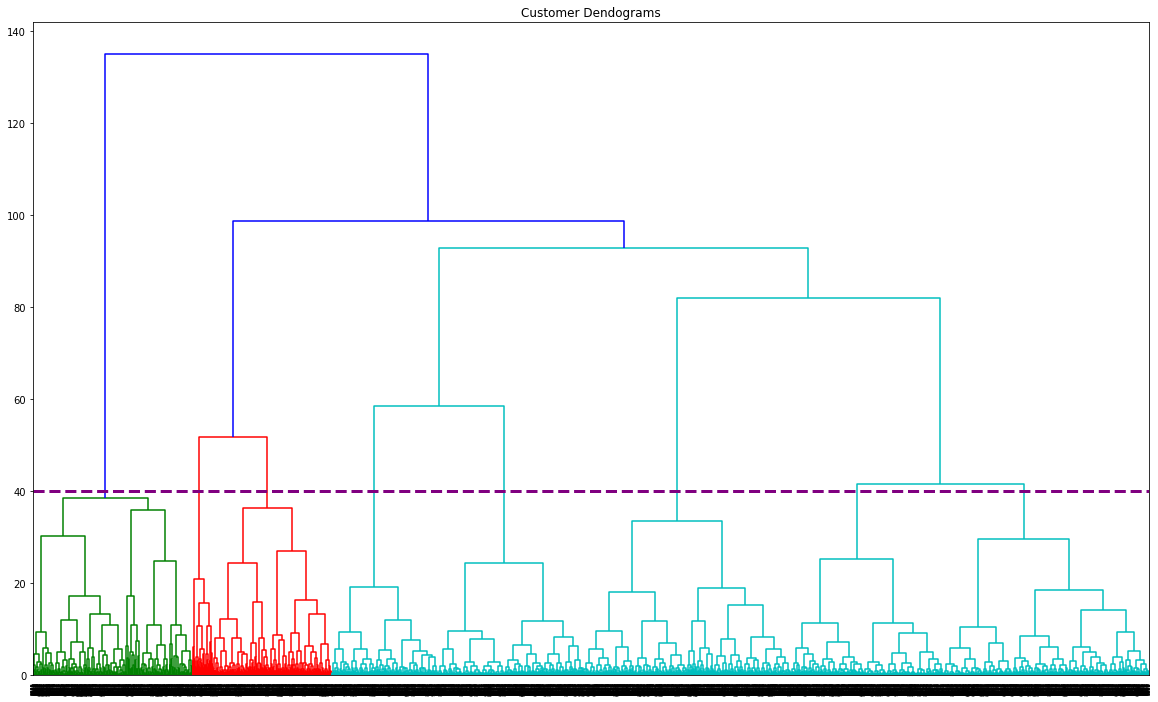

In [15]:
fig, ax = plt.subplots(1,1,figsize=(20, 12))

ax.set_title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X, method='ward'),ax=ax)
ax.axhline(y=40,linewidth=3,linestyle='--',color='purple')
plt.show()

In [17]:
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
labels=cluster.fit_predict(X)
x.loc[:,"Cluster"]=cluster.labels_

/home/jose/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/jose/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


# Who answered NO

In [18]:
x[x["Engaged"]==0].groupby("Cluster").mean()

,Customer Lifetime Value,Engaged,Months Since Policy Inception,Income
Cluster,,,,
0,21106.615763,0,50.148246,33339.967544
1,5503.350598,0,33.446910,17958.721748
2,5764.989344,0,82.001679,16047.240974
4,6283.256747,0,31.529412,71440.180000
5,5905.842851,0,80.243649,72029.667436


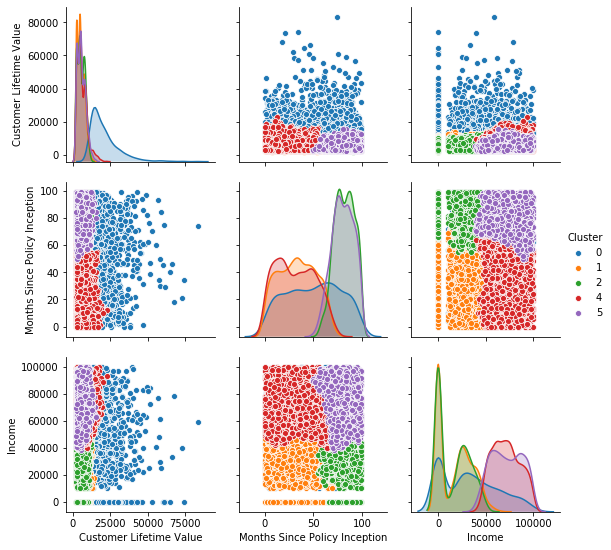

In [19]:
sns.pairplot(x[x["Engaged"]==0][['Customer Lifetime Value', 'Months Since Policy Inception',
       'Income', 'Cluster']],hue="Cluster")

# Who answered Yes

In [20]:
x[x["Engaged"]==1].groupby("Cluster").mean()

,Customer Lifetime Value,Engaged,Months Since Policy Inception,Income
Cluster,,,,
3,7854.871361,1,48.266055,38544.027523


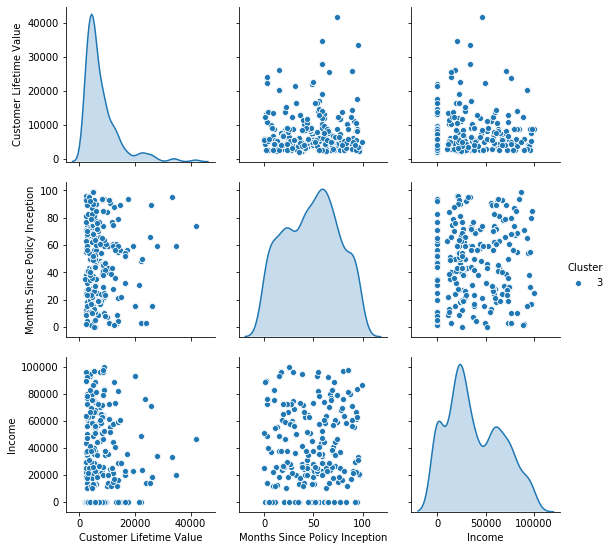

In [21]:
sns.pairplot(x[x["Engaged"]==1][['Customer Lifetime Value', 'Months Since Policy Inception',
       'Income', 'Cluster']],hue="Cluster")

# We are able to fully characterise our clients who answered yes from those who did not.

* __Moreover we are able to see the spectrum of the users who have answered affirmatively as well as the spectrum from those who did not.__

## But What is we want to make a difference between them, that is, what happen if we select the people who answered yes and then we try to understand its own segmentation.

## Those who answered No

In [22]:
x=df_to_explore[df_to_explore["Engaged"]==0][["Customer Lifetime Value",'Months Since Policy Inception',"Income"]]
X=StandardScaler().fit_transform(x)
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
labels=cluster.fit_predict(X)
x.loc[:,"Cluster"]=cluster.labels_

In [23]:
x.groupby("Cluster").mean()

,Customer Lifetime Value,Months Since Policy Inception,Income
Cluster,,,
0,5780.888013,64.704469,13146.379647
1,8421.708920,78.221932,68111.397737
2,6358.995640,32.450242,66039.783092
3,5579.256171,14.809723,17938.300084
4,19687.917343,33.057922,25544.524702
5,38999.543684,57.682927,43784.981707


# Let's visualize our results

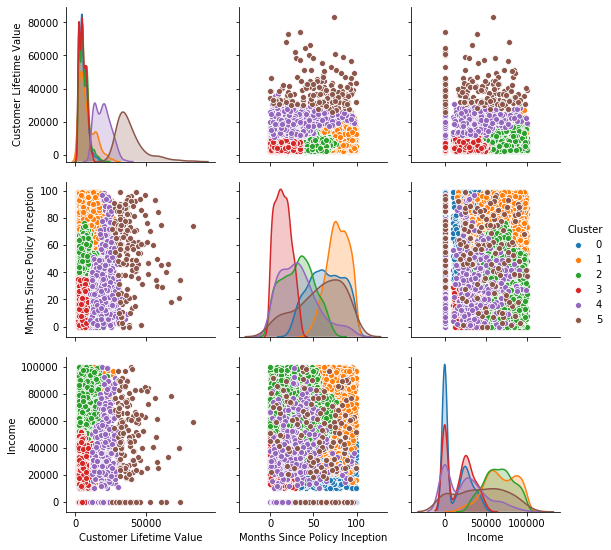

In [24]:
sns.pairplot(x,hue="Cluster")

 ![gif](./a.gif)

# Those who answered Yes

In [25]:
x=df_to_explore[df_to_explore["Engaged"]==1][["Customer Lifetime Value",'Months Since Policy Inception',"Income"]]
X=StandardScaler().fit_transform(x)
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
labels=cluster.fit_predict(X)
x.loc[:,"Cluster"]=cluster.labels_

In [26]:
x.groupby("Cluster").mean()

,Customer Lifetime Value,Months Since Policy Inception,Income
Cluster,,,
0,8564.501208,48.576642,20288.919708
1,6654.633226,47.740741,69419.950617


# Let's visualize our results

In [ ]:
sns.pairplot(x,hue="Cluster")

 ![gif](./b.gif)